<!-- Initialize **API** **managers** -->

In [1]:
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
import json
from datetime import datetime


print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'PARAMETERS.json', '__pycache__', 'data_analysis.ipynb']


(Optional) Update mongoDB for visualizing coordinates

In [2]:
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector


connector = DBConnector()
if connector.check_connection():
    print("Proceed with operations.")
else:
    print("Fix connection issues before proceeding.")

Connection to MongoDB is successful!
Proceed with operations.


1. Convert **JSON** to **CSV** so that **pandas** be able to use it
2. Create **csv** for every vehicle



In [3]:
import json
import pandas as pd
import os
from pathlib import Path
import csv


# Function to save a DataFrame to a CSV file
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Save the DataFrame to CSV
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop

while _cnt <= 100:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_df = pd.DataFrame(snapshot_data_list)
        
        # Save the DataFrame to CSV only if it's not empty
        save_to_csv(snapshot_df, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1

print("Process complete!")


**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_1_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_2_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_3_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_4_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_5_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_6_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_7_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehi

Visualize data **dispersion**

1) Plot **unique** vehicles

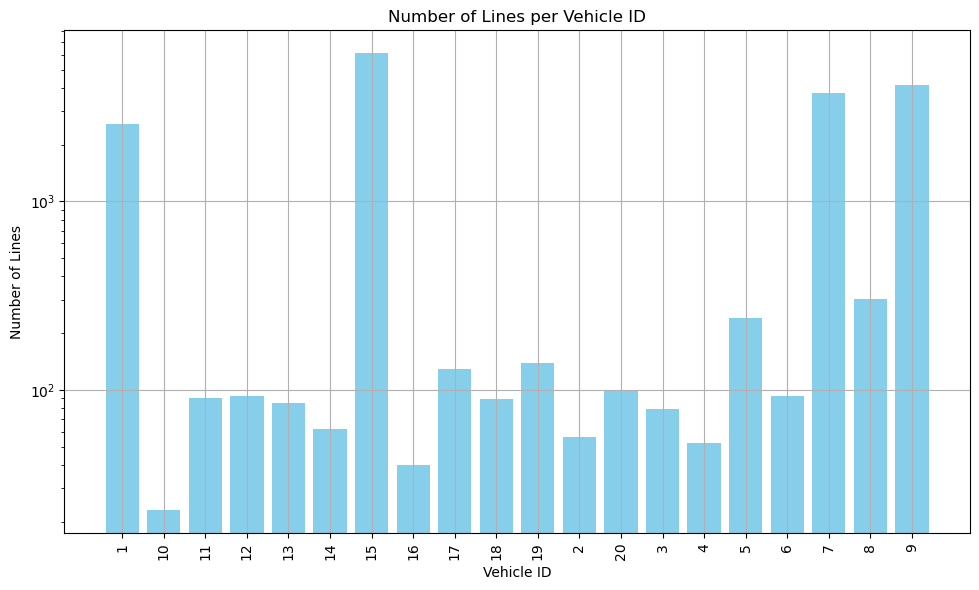

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the folder containing the CSV files
folder_path = "../../DataSets/API_Responses/Vehicle_Data/"  # Modify with your folder path

# Initialize an empty dictionary to store vehicleId (as a string) and its corresponding row count
vehicle_lines = {}

# Loop through the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv") and file_name.startswith("Vehicle_"):
        # Extract the vehicleId from the file name (assuming the naming convention is 'Vehicle_<id>.csv')
        vehicle_id = file_name.split('_')[1].split('.')[0]  # Keep it as a string
        
        # Ensure vehicle_id is only the number (strip any potential extra text)
        vehicle_id = vehicle_id.replace('Vehicle', '')  # Remove 'Vehicle' if present
        
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file to count the number of rows (excluding the header)
        try:
            df = pd.read_csv(file_path)
            vehicle_lines[vehicle_id] = len(df)  # Store the line count for each vehicleId
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

# Sort the dictionary by vehicleId (ascending order)
sorted_vehicle_lines = dict(sorted(vehicle_lines.items()))

# Convert the sorted dictionary to two lists for plotting
vehicle_ids = list(sorted_vehicle_lines.keys())
line_counts = list(sorted_vehicle_lines.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(vehicle_ids, line_counts, color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Lines')
plt.title('Number of Lines per Vehicle ID')
plt.xticks(vehicle_ids, rotation=90)  # Rotate vehicle IDs if needed
plt.tight_layout()
plt.grid()

#! Log the values for better visualization
plt.yscale("log")


# Show the plot
plt.show()


Visualize data **dispersion**

Create **Velocity Dictionary** from Multiple CSV Files

In [6]:
import pandas as pd
import os

# Define the CSV file path
snapshot_file_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Replace with your actual file path

# Check if the file exists
if os.path.exists(snapshot_file_path) and os.path.getsize(snapshot_file_path) > 0:
    try:
        # Read the CSV file into a DataFrame
        snapshot_df = pd.read_csv(snapshot_file_path)

        # Ensure the columns exist
        if "lat" in snapshot_df.columns and "lng" in snapshot_df.columns and "velocity" in snapshot_df.columns:
            #* Create a dictionary to store coordinate pairs and corresponding velocities
            coordinates_dict = {}
        
            for index, row in snapshot_df.iterrows():
                #! Get the coordinate pair and velocity
                lat = round(row["lat"], 4)  #! Round to 4 decimals
                lng = round(row["lng"], 4)  #! Round to 4 decimals
                velocity = row["velocity"]

                #! Create a key for the coordinate pair
                coordinate_pair = (lat, lng)

                #* Add the velocity to the list of velocities for the coordinate pair
                if coordinate_pair not in coordinates_dict:
                    coordinates_dict[coordinate_pair] = [velocity]
                else:
                    coordinates_dict[coordinate_pair].append(velocity)

            print("Coordinates dictionary created successfully!")

        else:
            print("Error: CSV file is missing required columns ('lat', 'lng', 'velocity')")
    
    except Exception as e:
        print(f"Unexpected error: {e}")
else:
    print(f"Error: File is empty or does not exist at path {snapshot_file_path}")
    


print("First 5 coordinate pairs and velocities:")
for index, (coords, velocities) in enumerate(coordinates_dict.items()):
    if index >= 5:  
        break
    print(f"Coordinates: {coords}, Velocities: {velocities}")
print(f"\nTotal unique coordinate pairs: {len(coordinates_dict)}")



Coordinates dictionary created successfully!
First 5 coordinate pairs and velocities:
Coordinates: (38.0346, 23.7481), Velocities: [0.0, 9.0]
Coordinates: (38.0346, 23.7482), Velocities: [10.0, 8.0, 10.0]
Coordinates: (38.0345, 23.7482), Velocities: [0.0, 0.0, 6.0, 27.0, 7.0, 11.0]
Coordinates: (38.0344, 23.7482), Velocities: [6.0, 0.0, 0.0, 37.0]
Coordinates: (38.0344, 23.7483), Velocities: [16.0, 0.0]

Total unique coordinate pairs: 72
